In [3]:
#python libraries
import os
import re
from datetime import datetime
import pytz
import copy

#other ML libraries
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#ploting
import matplotlib.pyplot as plt
%matplotlib inline

/home/henrikhestnes/anaconda3/envs/LSTM/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### DATA CLEANING

In [4]:
#Import Disruptive & Netatmo Sensor Data

# assign variables
directory = './storedData/'
sensor_data = pd.DataFrame()
sensor_data['timestamp'] = None #in order to merge based on it 

measurement_types = ["Door", "Water", "Humidity_temperature", "Humidity_humidity", 
                     "Humidifier_humidity", "Humidifier_temperature","Temperature",
                     "Hum_temperature", "Hum_humidity"]
discrete_measurement_types = ["Door", "Water"]


# iterate over files in that directory and concat into 1 big dataframe based on timestamps
for filename in os.listdir(directory): 
    file = os.path.join(directory, filename)
    if os.path.isfile(file):    
        df = pd.read_csv(file)
        df.drop(columns=df.columns[0], inplace=True) # dropping unnamed coloumn for indexing in .cvs file

        df['timestamp'] = pd.to_datetime(df['timestamp'],  utc=True)#.dt.tz_convert('Europe/Rome') #set timezone correctly if not correct in local time
        df.set_index("timestamp", inplace=True)
        for measurement_name in df.columns:
            measurement_frame = df[measurement_name].to_frame()

            measurement_name_list = re.findall("([A-Z0-9][^A-Z]*)", measurement_name) # Splitting string on capital letters
            measurement_type = measurement_name_list[-1]
            if measurement_type not in measurement_types: #Temperature measurements does not have temperature in their name
                measurement_type = "Temperature"
                measurement_name_list.append(measurement_type)
            #Renaming coloumn for consistent naming
            coloumn_name = f"{''.join(measurement_name_list[:-1])}_{measurement_type.lower()}"
            measurement_frame.rename(columns={measurement_frame.columns[0]: coloumn_name}, inplace=True)
            # print(f"key: {measurement_frame.columns[0]} Value: {coloumn_name}")
            if measurement_type in discrete_measurement_types:
                #For Water Detection:
                #NOT_PRESENT == No water detected = 0
                #PRESENT     == water detected    = 1

                #For Door Sensors: - this is because sensor changes state based on if it detects objects in front of it
                #NOT_PRESENT == DOOR IS OPEN     = 0
                #PRESENT     == DOOR IS CLOSED   = 1
                
                measurement_frame.replace(['NOT_PRESENT', 'PRESENT'],[0, 1], inplace=True)
                measurement_frame = measurement_frame.resample('15T').ffill()
            else: #Contious measurement
                measurement_frame  = measurement_frame.resample('15T').mean().interpolate() #Resample to managable timestamps by taking mean of 5 minute slots and linear interpolating NaNs, i.e. 5, 10, 15, 20 minutes etc..

    
            sensor_data = pd.merge(sensor_data, measurement_frame, on='timestamp', how="outer")  

sensor_data.set_index("timestamp", inplace=True)
sensor_data.sort_index(axis=0, inplace=True) #Sorting by timestamp
sensor_data.sort_index(axis=1, inplace=True) #Sorting columns alpabetically

#Postprocesing the data in order to get rid of the NaN Values
#ffill and fillna(0/1) to populate NaN values of the proximity with ffill and then set the values before first valid value to DOOR_CLOSED/NO_WATER
sensor_data.loc[:, sensor_data.columns.str.endswith('door')] = sensor_data.loc[:, sensor_data.columns.str.endswith('door')].ffill().fillna(1)
sensor_data.loc[:, sensor_data.columns.str.endswith('water')] = sensor_data.loc[:, sensor_data.columns.str.endswith('water')].ffill().fillna(0)


# # #linearly interpolate temperature and humidity values:
sensor_data.loc[:, sensor_data.columns.str.endswith('temperature')]  = sensor_data.loc[:, sensor_data.columns.str.endswith('temperature')].interpolate().bfill().ffill()
sensor_data.loc[:, sensor_data.columns.str.endswith('humidity')]  = sensor_data.loc[:, sensor_data.columns.str.endswith('humidity')].interpolate().bfill().ffill()

### FEATURE ENGINEERING ###

In [5]:
#Add hand-designed time-of-day and day-of-year features
min_in_hour = 60
min_in_day = 24*min_in_hour
sensor_data['sin_daily'] = np.sin(2*np.pi*(sensor_data.index.minute + sensor_data.index.hour*min_in_hour)/min_in_day).values
sensor_data['cos_daily'] = np.cos(2*np.pi*(sensor_data.index.minute + sensor_data.index.hour*min_in_hour)/min_in_day).values

days_in_year = 365.2425
sensor_data['sin_yearly'] = np.sin(2*np.pi*(sensor_data.index.day_of_year)/days_in_year).values
sensor_data['cos_yearly'] = np.cos(2*np.pi*(sensor_data.index.day_of_year)/days_in_year).values

days_in_week = 7
sensor_data['sin_weekly'] = np.sin(2*np.pi*(sensor_data.index.day_of_week)/days_in_week).values
sensor_data['cos_weekly'] = np.cos(2*np.pi*(sensor_data.index.day_of_week)/days_in_week).values

In [6]:
sensor_data.describe()

,0BGuest_door,0BRoom_temperature,0BTCeiling_temperature,0BTFloor_temperature,0B_door,0Bathroom_water,1BathRoom_water,1Entrance1_temperature,1GuestRoom_temperature,1MainBR_hum_humidity,...,2LivingRoom_humidifier_temperature,2OfficeDesk_temperature,2Office_door,2Stair_temperature,sin_daily,cos_daily,sin_yearly,cos_yearly,sin_weekly,cos_weekly
count,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,...,39166.000000,39166.000000,39166.000000,39166.000000,3.916600e+04,3.916600e+04,39166.000000,39166.000000,39166.000000,39166.000000
mean,0.731093,20.219920,20.493444,19.880145,0.159577,0.003396,0.113925,23.061776,18.888458,38.371860,...,21.596080,20.351772,0.398739,21.664779,4.776617e-05,-1.797791e-05,0.048966,0.089977,-0.004115,0.000289
std,0.443397,2.777353,2.358416,2.570392,0.366218,0.058175,0.317725,1.703731,3.133083,9.052182,...,2.549447,3.360557,0.489645,2.543805,7.071023e-01,7.071294e-01,0.686751,0.719656,0.707943,0.706275
min,0.000000,10.250000,15.100000,14.150000,0.000000,0.000000,0.000000,15.300000,5.700000,19.000000,...,10.550000,10.525000,0.000000,10.950000,-1.000000e+00,-1.000000e+00,-0.999999,-0.999979,-0.974928,-0.900969
25%,0.000000,18.800000,18.750000,18.050000,0.000000,0.000000,0.000000,22.300000,17.650000,31.000000,...,20.100000,18.383333,0.000000,20.250000,-7.071068e-01,-7.071068e-01,-0.639648,-0.641690,-0.781831,-0.900969
50%,1.000000,20.200000,20.483333,19.750000,0.000000,0.000000,0.000000,23.450000,19.200000,37.000000,...,21.550000,20.200000,0.000000,21.583333,1.224647e-16,-1.836970e-16,0.164758,0.176443,0.000000,-0.222521
75%,1.000000,22.000000,22.100000,21.650000,0.000000,0.000000,0.000000,24.250000,20.925000,45.000000,...,23.300000,22.366667,1.000000,23.116667,7.071068e-01,7.071068e-01,0.681936,0.811856,0.781831,0.623490
max,1.000000,27.450000,31.550000,27.750000,1.000000,1.000000,1.000000,26.900000,28.200000,67.000000,...,30.700000,32.425000,1.000000,30.000000,1.000000e+00,1.000000e+00,0.999986,0.999991,0.974928,1.000000


### DATA PREPROCESSING

In [7]:
data = sensor_data.copy()
cols_to_drop = ['1MainBR_hum_temperature', '2BalconyEntrance_temperature', '2LRWindow_temperature',
                '2LivingRoomCenter_humidity_temperature', '2LivingRoom_humidifier_temperature'] #due to correlation
data = data.drop(cols_to_drop, axis=1)

data["0BTLivingRoom_temperature"] = (data["0BTCeiling_temperature"] + data["0BTFloor_temperature"])/2
data = data.drop("0BTFloor_temperature", axis=1).drop("0BTCeiling_temperature", axis=1).sort_index(axis=1)

data["1Entrance_temperature"] = (data["1Entrance1_temperature"] + data["1StairBottom_temperature"])/2
data = data.drop("1Entrance1_temperature", axis=1).drop("1StairBottom_temperature", axis=1).sort_index(axis=1)

drop_hum_and_water_data = True
if drop_hum_and_water_data:
    data = data.drop(data.columns[data.columns.str.endswith('humidity')], axis=1)
    data = data.drop(data.columns[data.columns.str.endswith('water')], axis=1)

In [17]:
train_df_1 = data.loc[(data.index.month < 7) & (data.index.year == 2022)].copy()
train_df_2 = data.loc[((data.index.month > 8) & (data.index.year == 2022))|(data.index.year == 2023)].copy()
val_df = data.loc[(data.index.month == 8) & (data.index.year == 2022)].copy()
test_df = data.loc[(data.index.month == 7) & (data.index.year == 2022)].copy()

train_df = pd.concat([train_df_1, train_df_2])
train_temp = train_df.loc[:, data.columns.str.endswith('temperature')].drop("1OutdoorEntrance_temperature", axis=1).sort_index(axis=1)
train_outdoor = train_df.loc[:, ["1OutdoorEntrance_temperature"]]
train_door = train_df.loc[:, data.columns.str.endswith('door')].sort_index(axis=1)
train_timing = train_df.iloc[:, -6:]

val_temp = val_df.loc[:, data.columns.str.endswith('temperature')].drop("1OutdoorEntrance_temperature", axis=1).sort_index(axis=1)
val_outdoor = val_df.loc[:, ["1OutdoorEntrance_temperature"]]
val_door = val_df.loc[:, data.columns.str.endswith('door')].sort_index(axis=1)
val_timing = val_df.iloc[:, -6:]

test_temp = test_df.loc[:, data.columns.str.endswith('temperature')].drop("1OutdoorEntrance_temperature", axis=1).sort_index(axis=1)
test_outdoor = test_df.loc[:, ["1OutdoorEntrance_temperature"]]
test_door = test_df.loc[:, data.columns.str.endswith('door')].sort_index(axis=1)
test_timing = test_df.iloc[:, -6:]

print(f"Shape of train_df = {train_df.shape}, Shape of val_df = {val_df.shape}, Shape of test_df = {test_df.shape}")
print(f"Shape of train_labels = {train_temp.shape}, Shape of val_labels = {val_temp.shape}, Shape of test_labels = {test_temp.shape}")
train_df.describe()

Shape of train_df = (33214, 22), Shape of val_df = (2976, 22), Shape of test_df = (2976, 22)
Shape of train_labels = (33214, 10), Shape of val_labels = (2976, 10), Shape of test_labels = (2976, 10)


,0BGuest_door,0BRoom_temperature,0BTLivingRoom_temperature,0B_door,1Entrance_temperature,1GuestRoom_temperature,1MainRoom_temperature,1Main_door,1OutdoorEntrance_temperature,2Cooking_temperature,...,2LivingRoomCenter_temperature,2OfficeDesk_temperature,2Office_door,2Stair_temperature,cos_daily,cos_weekly,cos_yearly,sin_daily,sin_weekly,sin_yearly
count,33214.000000,33214.000000,33214.000000,33214.000000,33214.000000,33214.00000,33214.000000,33214.000000,33214.000000,33214.000000,...,33214.000000,33214.000000,33214.000000,33214.000000,3.321400e+04,33214.000000,33214.000000,3.321400e+04,33214.000000,33214.000000
mean,0.783676,19.965860,20.082758,0.160896,21.885401,18.38782,17.732185,0.995484,5.661794,21.440466,...,21.174312,19.932883,0.400102,21.388867,-2.119958e-05,-0.002263,0.254857,5.632594e-05,-0.003598,0.141731
std,0.411744,2.869333,2.547262,0.367441,1.572943,3.10508,3.001057,0.067052,6.300518,2.950314,...,2.549149,3.319743,0.489926,2.603589,7.071334e-01,0.706761,0.653996,7.071015e-01,0.707461,0.698052
min,0.000000,10.250000,14.650000,0.000000,14.658333,5.70000,3.200000,0.000000,-14.650000,10.000000,...,10.416667,10.525000,0.000000,10.950000,-1.000000e+00,-0.900969,-0.999611,-1.000000e+00,-0.974928,-0.999999
25%,1.000000,18.550000,18.175000,0.000000,21.341667,17.20000,16.400000,1.000000,1.500000,19.700000,...,19.775000,18.016667,0.000000,20.000000,-7.071068e-01,-0.900969,-0.287174,-7.071068e-01,-0.781831,-0.569805
50%,1.000000,19.900000,20.025000,0.000000,22.200000,18.85000,18.100000,1.000000,4.950000,21.250000,...,21.066667,19.733333,0.000000,21.225000,-1.836970e-16,-0.222521,0.433564,1.224647e-16,0.000000,0.337308
75%,1.000000,21.750000,21.950000,0.000000,22.886458,20.15000,19.500000,1.000000,9.850000,23.259375,...,22.800000,21.916667,1.000000,22.766667,7.071068e-01,0.623490,0.859013,7.071068e-01,0.781831,0.746600
max,1.000000,27.400000,28.725000,1.000000,26.125000,28.20000,27.350000,1.000000,32.500000,37.650000,...,30.416667,32.150000,1.000000,29.800000,1.000000e+00,1.000000,0.999991,1.000000e+00,0.974928,0.999986


### DEFINE ASSET

In [18]:
import asset
import importlib
importlib.reload(asset)

gfBedroom = asset.Zone("gfBedroom",       [0.34146, 1.36584, 1.36584, 0.34146],           [41652.8784, 402850.8])
gfLivingroom = asset.Zone("gfLivingroom", [0.598068, 2.392272, 2.392272, 0.598068],       [157355.3184, 747837.36])
stairs = asset.Zone("stairs",             [0.4067498, 1.6269992, 1.6269992, 0.4067498],   [69035.7892, 647290.4264])
gfBath = asset.Zone("gfBath",             [0.2705976, 1.0823904, 1.0823904, 0.2705976],   [44159.7646, 434698.992])
gfStorage = asset.Zone("gfStorage",       [0.2901384, 1.1605536, 1.1605536, 0.2901384],   [49173.537, 466090.128])
f1Guestroom = asset.Zone("f1Guestroom",   [0.366948, 1.467792, 1.467792, 0.366948],       [49944.8866, 443795.76])
f1Mainroom = asset.Zone("f1Mainroom",     [0.421254, 1.685016, 1.685016, 0.421254],       [66721.7404, 525431.88])
f1Sleep3 = asset.Zone("f1Sleep3",         [0.370791, 1.483164, 1.483164, 0.370791],       [49559.2118, 486390.42])
f1Bath = asset.Zone("f1Bath",             [0.172752, 0.691008, 0.691008, 0.172752],       [37796.1304, 277515.84])
f1Storage = asset.Zone("f1Storage",       [0.423831, 1.695324, 1.695324, 0.423831],       [26033.049, 673890.636])
f1Entrance = asset.Zone("f1Entrance",     [0.123192, 0.492768, 0.492768, 0.123192],       [88512.3666, 197900.64])
f2Livingroom = asset.Zone("f2Livingroom", [2.6243349, 10.4973396, 10.4973396, 2.6243349], [345178.946, 3373189.904])
f2Office = asset.Zone("f2Office",         [0.3805635, 1.522254, 1.522254, 0.3805635],     [42424.228, 462828.5916])
zones = [gfBedroom, gfLivingroom, stairs, gfBath, gfStorage, f1Guestroom, f1Mainroom, f1Sleep3, f1Bath, f1Storage, f1Entrance, f2Livingroom, f2Office]

connections =  [{"rooms": ["gfBedroom", "gfLivingroom"],    "R": 10.35216, "C": 179373.6}, 
                {"rooms": ["gfBedroom", "stairs"],          "R": 4.43664, "C": 76874.4},
                {"rooms": ["gfBedroom", "f1Guestroom"],     "R": 2.016, "C": 207012.6},
                {"rooms": ["gfLivingroom", "gfBath"],       "R": 9.785256, "C": 169550.76},
                {"rooms": ["gfLivingroom", "stairs"],       "R": 38.10888, "C": 0},
                {"rooms": ["gfLivingroom", "f1Entrance"],   "R": 2.7216, "C": 279467.01},
                {"rooms": ["gfLivingroom", "f1Mainroom"],   "R": 3.2256, "C": 331220.16},
                {"rooms": ["gfBath", "gfStorage"],          "R": 5.91552, "C": 102499.2},
                {"rooms": ["gfBath", "f1Sleep3"],           "R": 1.12896, "C": 115927.056},
                {"rooms": ["gfStorage", "stairs"],          "R": 4.43664, "C": 76874.4},
                {"rooms": ["gfStorage", "f1Bath"],          "R": 1.82784, "C": 187691.424},
                {"rooms": ["f1Guestroom", "f1Mainroom"],    "R": 7.3944, "C": 128124},
                {"rooms": ["f1Guestroom", "f1Entrance"],    "R": 4.43664, "C": 76874.4},
                {"rooms": ["f1Guestroom", "stairs"],        "R": 4.43664, "C": 76874.4},
                {"rooms": ["f1Guestroom", "f2Livingroom"],  "R": 2.4192, "C": 248415.12},
                {"rooms": ["f1Mainroom", "f1Sleep3"],       "R": 5.17608, "C": 89686.8},
                {"rooms": ["f1Mainroom", "f1Entrance"],     "R": 6.65496, "C": 115311.6},
                {"rooms": ["f1Mainroom", "f2Livingroom"],   "R": 3.2256, "C": 331220.16},
                {"rooms": ["f1Sleep3", "f1Entrance"],       "R": 12.57048, "C": 217810.8},
                {"rooms": ["f1Sleep3", "f2Livingroom"],     "R": 2.39904, "C": 246344.994},
                {"rooms": ["f1Entrance", "f1Bath"],         "R": 3.94368, "C": 68332.8},
                {"rooms": ["f1Entrance", "stairs"],         "R": 38.10888, "C": 0},
                {"rooms": ["f1Entrance", "f2Livingroom"],   "R": 4.28064, "C": 439556.754},
                {"rooms": ["f1Bath", "f1Storage"],          "R": 0.72216, "C": 116010.72},
                {"rooms": ["f1Bath", "stairs"],             "R": 4.43664, "C": 76874.4},
                {"rooms": ["f1Bath", "f2Office"],           "R": 1.82784, "C": 187691.424},
                {"rooms": ["f2Livingroom", "f2Office"],     "R": 12.089844, "C": 209482.74},
                {"rooms": ["f2Livingroom", "stairs"],       "R": 43.131254, "C": 0},
                {"rooms": ["f2Office", "stairs"],           "R": 4.729335, "C": 81945.975}]

house = asset.Asset(zones, connections)


### DEFINE PBM MODEL

In [241]:
import PBM
importlib.reload(PBM)
thermoPBM = PBM.thermoPBM(house)

In [113]:
def pbm_temp_from_sensor(sensor_sample):
    pbm_temp = np.zeros((13))
    pbm_temp[0] = sensor_sample[0] #gfBedroom
    pbm_temp[1] = sensor_sample[1] #gfLivingroom
    pbm_temp[2] = (sensor_sample[9] + sensor_sample[2])/2 #stairs
    pbm_temp[3] = sensor_sample[1] #gfBath
    pbm_temp[4] = sensor_sample[1] #gfStorage
    pbm_temp[5] = sensor_sample[3] #f1Guestroom
    pbm_temp[6] = sensor_sample[4] #f1Mainroom
    pbm_temp[7] = sensor_sample[4] #f1Sleep3
    pbm_temp[8] = sensor_sample[2] #f1Bath
    pbm_temp[9] = sensor_sample[2] #f1Storage
    pbm_temp[10] = sensor_sample[2] #f1Entrance
    pbm_temp[11] = sensor_sample[7] #f2Livingroom
    pbm_temp[12] = sensor_sample[8] #f2Office
    return pbm_temp

In [475]:
pbm_out = np.zeros((test_outdoor.shape[0], 13))
pbm_out_wall = np.zeros((test_outdoor.shape[0], 13))

T_outdoor_start = test_outdoor.iloc[0].values
T_room = pbm_temp_from_sensor(test_temp.iloc[0])
T_wall = np.zeros(13)

delta_t = 120
N = 20000
for n, t_out in enumerate(test_outdoor.values):
    tmp = [T_room.copy()]
    for i in range(N):
        u_room, u_wall = thermoPBM.calculate_U(t_out)
        u_room = np.full(13, 9)
        u_room[11] = 30
        T_room, T_wall = thermoPBM.step(T_room, T_wall, u_room, u_wall, delta_t)
        tmp.append(T_room.copy())
    pbm_out[n] = T_room
    pbm_out_wall[n] = T_wall
    

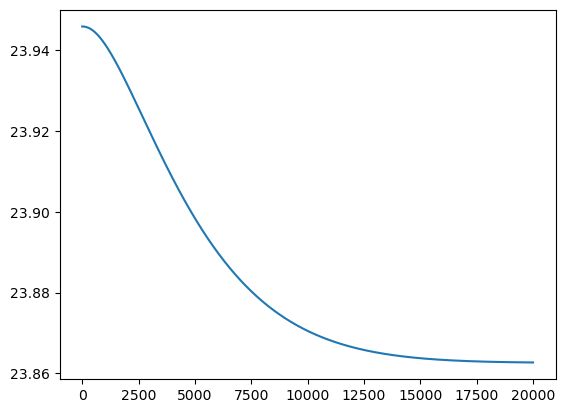

In [472]:
tmp = np.array(tmp)
plt.plot(tmp[:, 3])

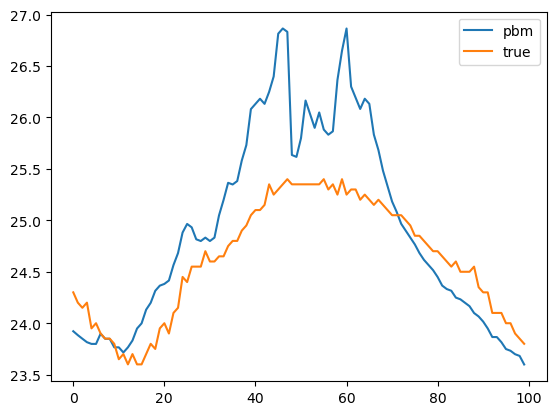

In [473]:
plt.plot(pbm_out[:100, 0], label="pbm")
# plt.plot(pbm_out_wall[:100, 0], label="pbm wall")
plt.plot(test_temp.iloc[:100, 0].values, label="true")
plt.legend()

### COMPARE OUTPUT WITH ESP-R AND MEASUREMENTS

In [282]:
espr_sim = pd.read_csv("./../PBM/esp-r_temp_pandas.csv", index_col=0)
espr_sim.index = pd.to_datetime(espr_sim.index)

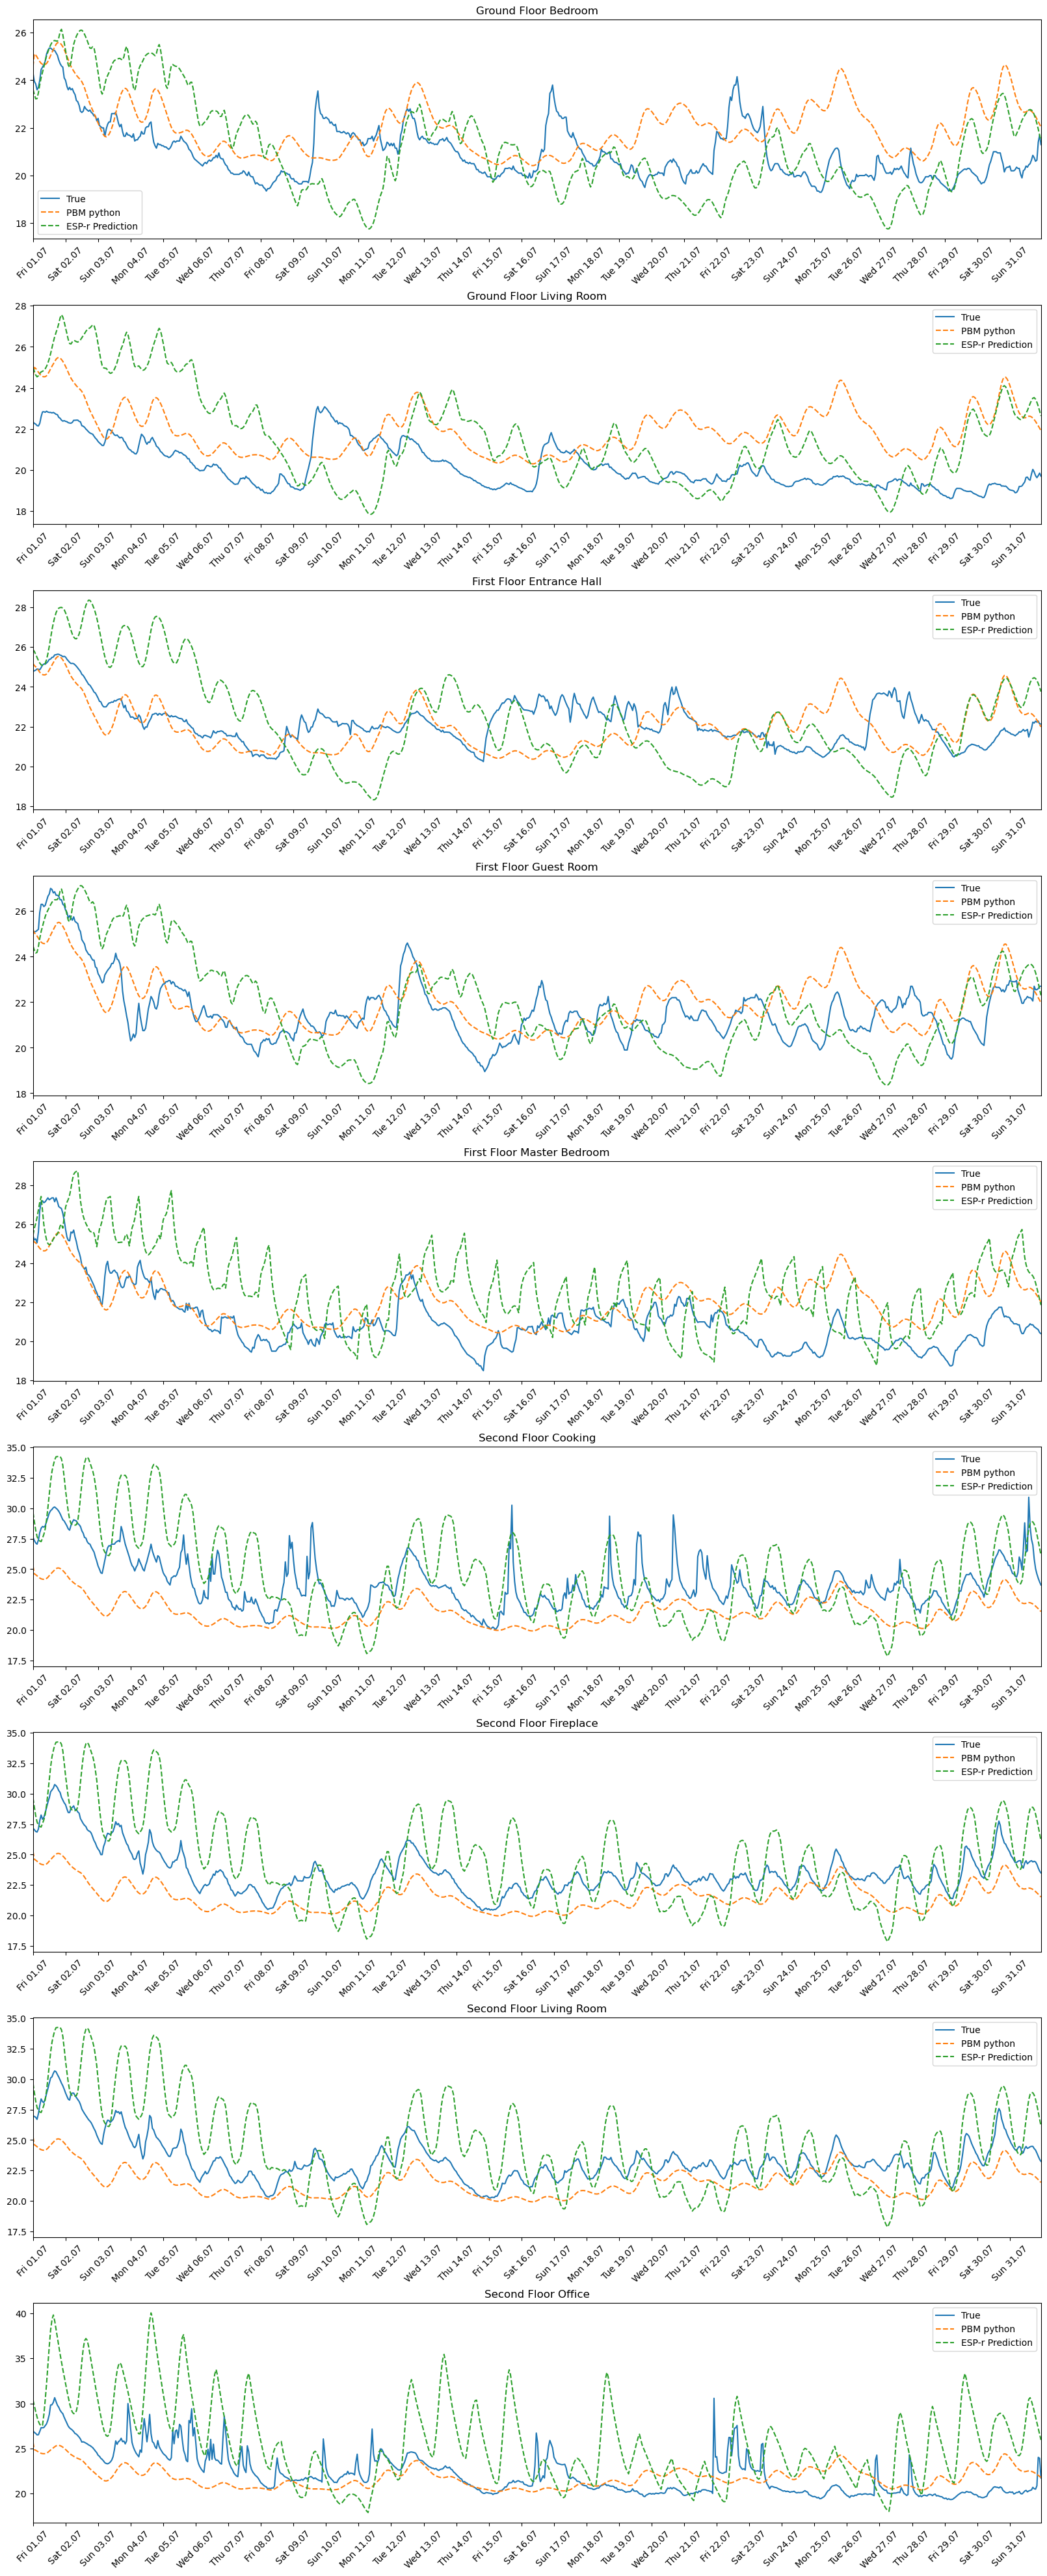

In [355]:
titles = ["Ground Floor Bedroom", "Ground Floor Living Room", "First Floor Entrance Hall",
          "First Floor Guest Room", "First Floor Master Bedroom", "Second Floor Cooking",
          "Second Floor Fireplace", "Second Floor Living Room", "Second Floor Office"]
pred_order = ['0BRoom_temperature', '0BTLivingRoom_temperature',
            '1Entrance_temperature', '1GuestRoom_temperature',
            '1MainRoom_temperature', '2Cooking_temperature',
            '2Fireplace_temperature', '2LivingRoomCenter_temperature',
            '2OfficeDesk_temperature']
pbm_compare_indices = [0, 1, 5, 6, 10, 11, 11, 11, 12]


fig,ax = plt.subplots(9,1,figsize=(20,50))
plt.subplots_adjust(hspace=0.3)

for i in range(espr_sim.shape[1] - 1):
    true = test_temp[::4].values[:, i]
    pbm_pred = pbm_out[::4, pbm_compare_indices][:, i]
    espr_pred = espr_sim[pred_order[i]]
    x = range(len(true))
    ax[i].plot(x, true, label="True")
    ax[i].plot(x, pbm_pred, '--', label="PBM python")
    ax[i].plot(x, espr_pred, '--', label="ESP-r Prediction")
    ax[i].set_title(f"{titles[i]}")
    ax[i].set_xticks(x[::24])
    ax[i].set_xticklabels([date.strftime("%a %d.%m") for date in espr_pred.index[::24].date], rotation=45)
    ax[i].margins(x=0)
    ax[i].legend()